In [35]:
import os
import cv2
import pickle
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
DATA_PATH = 'RetinalOCT_Dataset/RetinalOCT_Dataset'

LBP_RADIUS = 2
LBP_POINTS = 8 * LBP_RADIUS
GABOR_THETAS = np.arange(0, np.pi, np.pi / 4)

SAVE_FEATURES = True

classes = ['AMD','CNV','CSR','DME','DR','DRUSEN','MH','NORMAL']

In [24]:
def load_image(split):
    images = []
    labels = []
    split_path = os.path.join(DATA_PATH, split)

    # Ambil hanya folder kelas (tanpa hidden folder)
    folders = sorted([
        f for f in os.listdir(split_path)
        if os.path.isdir(os.path.join(split_path, f)) and not f.startswith('.')
    ])

    for i, folder in enumerate(folders):
        folder_path = os.path.join(split_path, folder)
        
        # Ambil file gambar dari folder tersebut
        files = sorted(os.listdir(folder_path))

        for file in files:
            file_path = os.path.join(folder_path, file)

            img = cv2.imread(file_path)
            if img is None:
                continue  # skip file corrupt

            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            images.append(img)
            labels.append(i)

    return np.array(images), np.array(labels)


In [9]:
def preprocess_oct(image):
    # 1. Denoising: bilateral filter lebih halus untuk struktur retina
    denoised = cv2.bilateralFilter(image, 9, 75, 75)
    
    # 2. Kontras lokal pakai CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)
    
    # 3. Normalisasi z-score (lebih stabil dari min-max)
    norm = (enhanced - np.mean(enhanced)) / (np.std(enhanced) + 1e-8)
    
    return enhanced, norm


In [10]:
def extract_features(img):
    enhanced, norm = preprocess_oct(img)
    features = []
    enhanced_uint8 = enhanced.astype(np.uint8)

    # ---- Statistik dasar ----
    features.extend([
        np.mean(norm),
        np.std(norm),
        skew(norm.ravel()),
        kurtosis(norm.ravel()),
        np.percentile(norm, 10),
        np.percentile(norm, 50),
        np.percentile(norm, 90)
    ])

    # ---- Sobel & edge ----
    sobelx = cv2.Sobel(enhanced, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(enhanced, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    features.extend([np.mean(grad_mag), np.std(grad_mag)])

    blurred = cv2.GaussianBlur(enhanced_uint8, (5, 5), 1)
    edges = cv2.Canny(blurred, 80, 200)
    edge_density = np.mean(edges > 0)
    features.append(edge_density)

    # ---- LBP ----
    lbp = local_binary_pattern(enhanced_uint8, LBP_POINTS, LBP_RADIUS, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=LBP_POINTS + 2, range=(0, LBP_POINTS + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-8)
    features.extend(hist)

    # ---- GLCM (Gray-Level Co-Occurrence Matrix) ----
    glcm = graycomatrix(enhanced_uint8, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    props = ['contrast', 'correlation', 'energy', 'homogeneity']
    for p in props:
        features.extend(graycoprops(glcm, p).flatten())

    # ---- Gabor filter bank ----
    for theta in GABOR_THETAS:
        kernel = cv2.getGaborKernel((15, 15), 4.0, theta, 10.0, 0.5, 0)
        fimg = cv2.filter2D(enhanced_uint8, cv2.CV_32F, kernel)
        features.extend([np.mean(fimg), np.std(fimg)])

    return np.array(features)

In [11]:
def extract_features_batch(images):    
    features = []
    total = len(images)
    
    for i, img in enumerate(images, 1):
        feature = extract_features(img)
        features.append(feature)

        if i % (total//10) == 0:
            percentage = int((i / total) * 100)
            print(f"==> {percentage}% done ({i}/{total} images)\n")
    
    print("Features Extraction Completed\n")
    return np.vstack(features)

In [25]:
train_img_raw, Y_train = load_image('train')
val_img_raw, Y_val = load_image('val')
test_img_raw, Y_test = load_image('test')

In [ ]:
X_train = extract_features_batch(train_img_raw)
X_val = extract_features_batch(val_img_raw)
X_test = extract_features_batch(test_img_raw)

==> 10% done (1840/18400 images)

==> 20% done (3680/18400 images)

==> 30% done (5520/18400 images)

==> 40% done (7360/18400 images)

==> 50% done (9200/18400 images)

==> 60% done (11040/18400 images)

==> 70% done (12880/18400 images)

==> 80% done (14720/18400 images)

==> 90% done (16560/18400 images)

==> 100% done (18400/18400 images)

Features Extraction Completed

==> 10% done (280/2800 images)

==> 20% done (560/2800 images)

==> 30% done (840/2800 images)

==> 40% done (1120/2800 images)

==> 50% done (1400/2800 images)

==> 60% done (1680/2800 images)

==> 70% done (1960/2800 images)

==> 80% done (2240/2800 images)

==> 90% done (2520/2800 images)

==> 100% done (2800/2800 images)

Features Extraction Completed

==> 10% done (280/2800 images)

==> 20% done (560/2800 images)

==> 30% done (840/2800 images)

==> 40% done (1120/2800 images)

==> 50% done (1400/2800 images)

==> 60% done (1680/2800 images)

==> 70% done (1960/2800 images)

==> 80% done (2240/2800 images)

==>

In [19]:
with open('image_features.pkl', 'wb') as file:
    pickle.dump({
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test
    }, file)

with open('image_features.pkl', 'rb') as file:
    data = pickle.load(file)

X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']

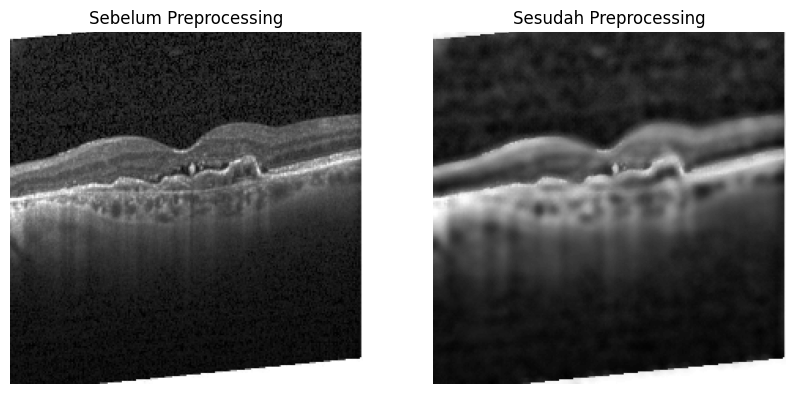

In [13]:
# 3. (Optional) visualization example
idx = min(49, len(train_img_raw) - 1)
original = train_img_raw[idx]
enhanced, _ = preprocess_oct(original)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original, cmap='gray')
plt.title('Sebelum Preprocessing')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced, cmap='gray')
plt.title('Sesudah Preprocessing')
plt.axis('off')

plt.show()

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [20]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# SVM

In [30]:
# di comment
svm = SVC(class_weight='balanced', random_state=42)

In [31]:
# di comment
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    cv=5,               # 5-fold cross validation
    n_jobs=-1,          # gunakan semua core CPU
    verbose=2,
    scoring='accuracy'
)

grid_svm.fit(X_train_scaled, Y_train)
print("Best SVM: ", grid_svm.best_estimator_)
best_svm = grid_svm.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   3.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   3.3s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   3.3s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   3.4s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   3.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   8.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   8.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   8.2s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   5.8s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   6.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   5.9s
[CV] END .....................C=0.1, gamma=scal

In [ ]:
# biar ga usah tunning lagi, nanti comment aja code tunningnya langsung run bagian ini

best_svm = SVC(
    C=100,
    gamma=0.01,
    kernel='rbf',          # kernel default hasil GridSearch jika kamu tidak ubah
    class_weight='balanced',
    random_state=42
)

best_svm.fit(X_train_scaled, Y_train)

In [36]:
with open('best_svm_model.pkl', 'wb') as file:
    pickle.dump(best_svm, file)

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)   

In [33]:
y_val_pred_svm = best_svm.predict(X_val_scaled)
y_test_pred_svm = best_svm.predict(X_test_scaled)

print("\nValidation Accuracy:", accuracy_score(Y_val, y_val_pred_svm))
print("Test Accuracy:", accuracy_score(Y_test, y_test_pred_svm))

print("\nClassification Report (Validation):")
print(classification_report(Y_val, y_val_pred_svm, target_names=classes))

print("\nClassification Report (Test):")
print(classification_report(Y_test, y_test_pred_svm, target_names=classes))

print("\nConfusion Matrix (Validation):")
print(confusion_matrix(Y_val, y_val_pred_svm))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(Y_test, y_test_pred_svm))


Validation Accuracy: 0.7482142857142857
Test Accuracy: 0.7378571428571429

Classification Report (Validation):
              precision    recall  f1-score   support

         AMD       0.65      0.73      0.69       350
         CNV       0.82      0.81      0.81       350
         CSR       0.84      0.83      0.84       350
         DME       0.90      0.93      0.92       350
          DR       0.65      0.57      0.61       350
      DRUSEN       1.00      1.00      1.00       350
          MH       0.51      0.52      0.51       350
      NORMAL       0.61      0.61      0.61       350

    accuracy                           0.75      2800
   macro avg       0.75      0.75      0.75      2800
weighted avg       0.75      0.75      0.75      2800


Classification Report (Test):
              precision    recall  f1-score   support

         AMD       0.66      0.66      0.66       350
         CNV       0.81      0.84      0.82       350
         CSR       0.84      0.80      0.82

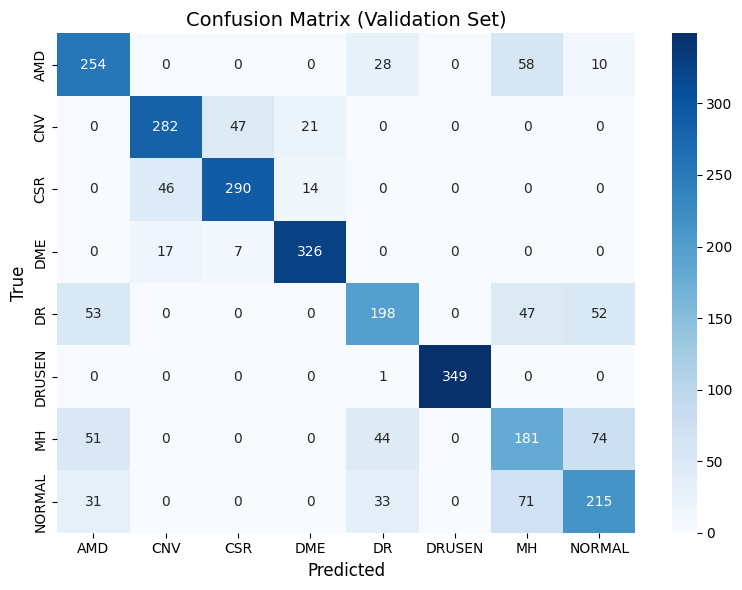

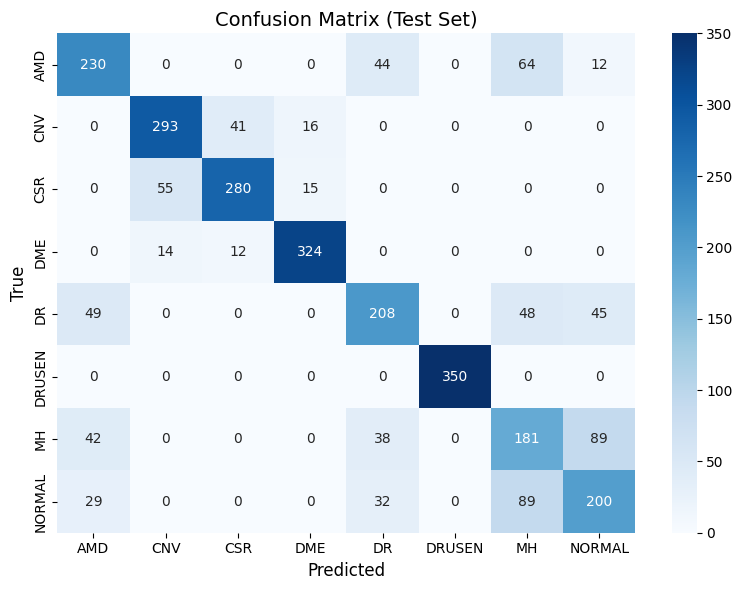

In [37]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=14)
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("True", fontsize=12)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(
    Y_val, 
    y_val_pred_svm, 
    classes, 
    title="Confusion Matrix (Validation Set)"
)

plot_confusion_matrix(
    Y_test, 
    y_test_pred_svm, 
    classes, 
    title="Confusion Matrix (Test Set)"
)


# MLP

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [26]:
Y_train_enc = to_categorical(Y_train)
Y_val_enc = to_categorical(Y_val)
Y_test_enc = to_categorical(Y_test)

In [27]:
n_features = X_train.shape[1]
n_classes = Y_train_enc.shape[1]

In [29]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential()

    # Hidden layer 1
    model.add(Dense(
        units=hp.Int('units1', min_value=64, max_value=512, step=64),
        activation='relu',
        input_shape=(X_train_scaled.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)))

    # Hidden layer 2
    model.add(Dense(
        units=hp.Int('units2', min_value=32, max_value=256, step=32),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.1)))

    # Hidden layer 3
    model.add(Dense(
        units=hp.Int('units3', min_value=16, max_value=256, step=32),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout3', 0.2, 0.5, step=0.1)))

    # Output layer (jumlah neuron = jumlah kelas)
    model.add(Dense(Y_train_enc.shape[1], activation='softmax'))

    # Gunakan categorical_crossentropy karena label sudah one-hot
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Inisialisasi tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=8,
    executions_per_trial=1,
    directory='tuner_dir_bn',
    project_name='mlp_bn_test'
)

# Jalankan tuning
tuner.search(
    X_train_scaled, Y_train_enc,
    epochs=20,
    validation_data=(X_val_scaled, Y_val_enc),
    batch_size=32,
    verbose=1
)

# Ambil hyperparameter terbaik
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Bangun ulang model terbaik
best_mlp = build_model(best_hp)

# Callback untuk early stopping dan simpan model terbaik
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_mlp_bn_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Latih ulang model terbaik
history = best_mlp.fit(
    X_train_scaled, Y_train_enc,
    validation_data=(X_val_scaled, Y_val_enc),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluasi model terbaik
loss, acc = best_mlp.evaluate(X_val_scaled, Y_val_enc, verbose=0)
print(f"\n✅ Best Model Validation Accuracy (retrained): {acc:.4f}")

best_mlp.summary()

# Tampilkan semua hyperparameter terbaik
print("\n🔍 Best Hyperparameters:")
for k, v in best_hp.values.items():
    print(f"{k}: {v}") 

Trial 8 Complete [00h 00m 12s]
val_accuracy: 0.710357129573822

Best val_accuracy So Far: 0.7200000286102295
Total elapsed time: 00h 01m 37s


Epoch 1/30
555/575 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.4075 - loss: 1.4977
Epoch 1: val_accuracy improved from None to 0.60929, saving model to best_mlp_bn_model.keras
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4762 - loss: 1.2425 - val_accuracy: 0.6093 - val_loss: 0.8875
Epoch 2/30
545/575 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.5579 - loss: 1.0058
Epoch 2: val_accuracy improved from 0.60929 to 0.63000, saving model to best_mlp_bn_model.keras
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.5608 - loss: 0.9944 - val_accuracy: 0.6300 - val_loss: 0.8400
Epoch 3/30
566/575 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.5716 - loss: 0.9608
Epoch 3: val_accuracy improved from 0.63000 to 0.65571, saving model to best_mlp_bn_model.keras
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.5777 - loss: 0.9454 - val_accuracy: 0.6557 - val_loss: 0.8074
Epoch 4/30
565/575 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.6008 - loss: 0.9184
Epoch 4:

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 320)            │        16,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 160)            │        51,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 160)            │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,066 (847.92 KB)

 Trainable params: 72,024 (281.34 KB)

 Non-trainable params: 992 (3.88 KB)

 Optimizer params: 144,050 (562.70 KB)


🔍 Best Hyperparameters:
units1: 320
dropout1: 0.30000000000000004
units2: 160
dropout2: 0.2
units3: 16
dropout3: 0.4
learning_rate: 0.001
